# Import Modules

In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Connect to Coppelia

In [3]:
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)


0

# Codding to Plot

In [21]:
# Apenas para visualização de um referencial no plano
def plot_frame(Porg, R, c=['r', 'g']):
    
    axis_size = 3.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
        
    # X
    plt.quiver(*Porg[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

In [57]:
def plot3CompostTransformation(middleMatrix, destMatrix):
    aorg = np.array([0, 0])
    

    # Definindo Tbc
    Tbc = destMatrix
    pb_corg = Tbc[0:3, 3]
    Rbc = Tbc[:3,:3]

    # Definindo Tab
    Tab = middleMatrix
    pa_borg = Tab[:3, 3]
    Rab = Tab[:3,:3]
    
    # Definindo Tac
    Tac = Tab @ Tbc
    
    # Plotando os referenciais
    plt.figure()

    # The rotation matrix contain the axis orientation
    # Frame C->B
    pa_corg = np.array(Tac[:,3])
    ## Vector from the origin B to origin C from the perpective of A
    pb_corg_aux = Rab @ pb_corg
    Rac = Tac[:3,:3]
    ## plot the C axis and the vector from the B axis to C axis
    plot_frame(pa_corg, Rac, ['g', 'g'])
    plt.quiver(*pa_borg[:2], *pb_corg_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)

    # Frame B->A
    plot_frame(pa_borg, Rab, ['b', 'b'])
    plt.quiver(*aorg, *pa_borg[:2], color='b', angles='xy', scale_units='xy', scale=1)

    plt.axis('scaled')
    plt.axis((-15, 15, -15, 15))
    

# Codding to calculate the Transformation Matrix

In [38]:
# Function the invert a matrix
def invertMatrix(M):
    return np.linalg.inv(M)

In [39]:
# Get Object Position and Orientation
def getPositionAndOrientation(handle):
    pos = sim.getObjectPosition(handle)
    ori = sim.getObjectOrientation(handle)
    return pos, ori

In [40]:
# Get Rotation Matrix fixed on Z axis
def getRotationMatrixZfixed(pos, teta):
    rotationM = np.zeros((3,3))
    rotationM[2][2] = 1
    rotationM[0][0] = np.cos(teta)
    rotationM[0][1] = - np.sin(teta)
    rotationM[1][0] = np.sin(teta)
    rotationM[1][1] = np.cos(teta)

    return rotationM

In [41]:
# get the transformation from local axis to global axis

def getTransformationMatrixLocal2Global(handle):
    pos, ori = getPositionAndOrientation(handle)
    rotM = getRotationMatrixZfixed(pos, ori[2])
    transM = pos 
    scale = np.array([0, 0, 0, 1])

    # Local to Global
    M_L2G = np.column_stack((rotM, transM))
    M_L2G = np.row_stack((M_L2G, scale))

    return M_L2G



In [44]:
# Get the tranfortion from object to another object

def getTransformationMatrixObject2Object(sourceObject, desObject, printPlot = False):
    M_S2G = getTransformationMatrixLocal2Global(sourceObject)
    M_G2S = invertMatrix(M_S2G)
    M_D2G = getTransformationMatrixLocal2Global(desObject)

    if printPlot:
        plot3CompostTransformation(M_G2S, M_D2G)

    return M_G2S @ M_D2G

# Executing the Simulation

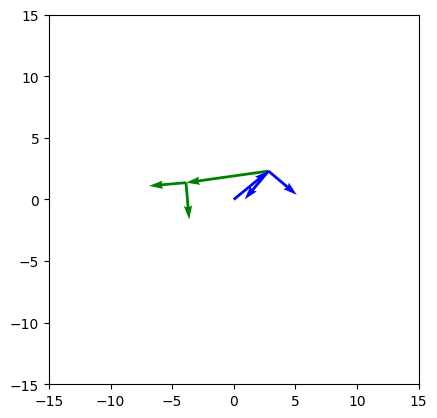

In [58]:
sim.startSimulation()

# Get Objects Handle
personHandle = sim.getObject("/Rapha")
chairHandle = sim.getObject("/Chair")
treeHandle = sim.getObject("/Tree")
diningTableHandle = sim.getObject("/diningTable")
rackHandle = sim.getObject("/Rack")
robotHanle = sim.getObject("/Robot")

# Get transformation Matriz from local to a object reference
result = getTransformationMatrixObject2Object(robotHanle, personHandle, printPlot = True)
# print(result)

sim.stopSimulation()